# Actor-Critic Algorithm in Reinforcement Learning

## Introduction

The **Actor-Critic** algorithm is a foundational method in reinforcement learning that combines the strengths of both policy-based and value-based approaches. It maintains two separate models:

1. **Actor**: A policy function $\pi_\theta(a|s)$ that selects actions
2. **Critic**: A value function $V_w(s)$ that evaluates state quality

This hybrid architecture addresses key limitations of pure policy gradient methods (high variance) and pure value-based methods (inability to handle continuous action spaces naturally).

## Theoretical Foundation

### Policy Gradient Theorem

The objective in policy-based reinforcement learning is to maximize the expected cumulative reward:

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \gamma^t r_t \right]$$

where $\gamma \in [0,1]$ is the discount factor and $\tau$ represents a trajectory.

The policy gradient theorem gives us:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) \cdot Q^{\pi}(s, a) \right]$$

### Advantage Function

The **advantage function** $A(s, a)$ measures how much better an action is compared to the average:

$$A^{\pi}(s, a) = Q^{\pi}(s, a) - V^{\pi}(s)$$

Using the advantage function reduces variance while maintaining an unbiased gradient estimate:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) \cdot A^{\pi}(s, a) \right]$$

### Temporal Difference (TD) Error

In practice, we estimate the advantage using the **TD error** $\delta_t$:

$$\delta_t = r_t + \gamma V_w(s_{t+1}) - V_w(s_t)$$

This TD error serves as an unbiased estimate of the advantage function.

## Actor-Critic Algorithm

### Update Rules

**Critic Update** (minimizing TD error):
$$w \leftarrow w + \alpha_w \delta_t \nabla_w V_w(s_t)$$

**Actor Update** (following policy gradient):
$$\theta \leftarrow \theta + \alpha_\theta \delta_t \nabla_\theta \log \pi_\theta(a_t|s_t)$$

where $\alpha_w$ and $\alpha_\theta$ are learning rates for the critic and actor respectively.

### Algorithm Pseudocode

```
Initialize actor parameters θ and critic parameters w
For each episode:
    Initialize state s
    For each step:
        Sample action a ~ π_θ(·|s)
        Execute a, observe r, s'
        Compute TD error: δ = r + γV_w(s') - V_w(s)
        Update critic: w ← w + α_w δ ∇_w V_w(s)
        Update actor: θ ← θ + α_θ δ ∇_θ log π_θ(a|s)
        s ← s'
```

## Implementation

We will implement an Actor-Critic agent to solve a simple continuous control task: balancing a pole on a cart (CartPole-like environment simulated from scratch).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Set random seed for reproducibility
np.random.seed(42)

### Custom CartPole Environment

We implement a simplified CartPole environment based on the classic control problem. The state consists of:
- Cart position $x$
- Cart velocity $\dot{x}$
- Pole angle $\theta$
- Pole angular velocity $\dot{\theta}$

The dynamics follow:

$$\ddot{\theta} = \frac{g \sin\theta + \cos\theta \left( \frac{-F - m_p l \dot{\theta}^2 \sin\theta}{m_c + m_p} \right)}{l \left( \frac{4}{3} - \frac{m_p \cos^2\theta}{m_c + m_p} \right)}$$

In [2]:
class CartPoleEnv:
    """Simple CartPole environment implementation."""
    
    def __init__(self):
        # Physical parameters
        self.gravity = 9.8
        self.cart_mass = 1.0
        self.pole_mass = 0.1
        self.total_mass = self.cart_mass + self.pole_mass
        self.pole_length = 0.5  # half-length
        self.force_mag = 10.0
        self.tau = 0.02  # time step
        
        # Termination thresholds
        self.x_threshold = 2.4
        self.theta_threshold = 12 * np.pi / 180  # 12 degrees
        
        self.state = None
        self.steps = 0
        self.max_steps = 200
        
    def reset(self):
        """Reset environment to initial state."""
        # Small random initial state
        self.state = np.random.uniform(-0.05, 0.05, size=(4,))
        self.steps = 0
        return self.state.copy()
    
    def step(self, action):
        """Execute action and return next state, reward, done."""
        x, x_dot, theta, theta_dot = self.state
        
        # Apply force based on action (0 = left, 1 = right)
        force = self.force_mag if action == 1 else -self.force_mag
        
        # Physics calculations
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        temp = (force + self.pole_mass * self.pole_length * theta_dot**2 * sin_theta) / self.total_mass
        theta_acc = (self.gravity * sin_theta - cos_theta * temp) / \
                    (self.pole_length * (4.0/3.0 - self.pole_mass * cos_theta**2 / self.total_mass))
        x_acc = temp - self.pole_mass * self.pole_length * theta_acc * cos_theta / self.total_mass
        
        # Euler integration
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * x_acc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * theta_acc
        
        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1
        
        # Check termination
        done = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold or theta > self.theta_threshold or
            self.steps >= self.max_steps
        )
        
        # Reward: +1 for each step the pole stays balanced
        reward = 1.0 if not done else 0.0
        
        return self.state.copy(), reward, done

### Actor-Critic Agent

We implement a tabular-style Actor-Critic using linear function approximation with tile coding features for simplicity and interpretability.

In [3]:
class ActorCriticAgent:
    """Actor-Critic agent with linear function approximation."""
    
    def __init__(self, state_dim=4, n_actions=2, n_features=256):
        self.n_actions = n_actions
        self.n_features = n_features
        
        # Feature extraction parameters (random Fourier features)
        self.feature_weights = np.random.randn(state_dim, n_features) * 0.5
        self.feature_bias = np.random.uniform(0, 2 * np.pi, n_features)
        
        # Actor parameters (policy weights)
        self.theta = np.zeros((n_features, n_actions))
        
        # Critic parameters (value function weights)
        self.w = np.zeros(n_features)
        
        # Learning rates
        self.alpha_actor = 0.001
        self.alpha_critic = 0.01
        self.gamma = 0.99  # Discount factor
        
    def get_features(self, state):
        """Extract features from state using random Fourier features."""
        return np.cos(state @ self.feature_weights + self.feature_bias)
    
    def get_policy(self, state):
        """Get action probabilities using softmax policy."""
        features = self.get_features(state)
        logits = features @ self.theta
        # Numerically stable softmax
        logits = logits - np.max(logits)
        exp_logits = np.exp(logits)
        return exp_logits / np.sum(exp_logits)
    
    def select_action(self, state):
        """Sample action from policy."""
        probs = self.get_policy(state)
        return np.random.choice(self.n_actions, p=probs)
    
    def get_value(self, state):
        """Get state value from critic."""
        features = self.get_features(state)
        return features @ self.w
    
    def update(self, state, action, reward, next_state, done):
        """Update actor and critic parameters."""
        features = self.get_features(state)
        
        # Compute TD error (advantage estimate)
        current_value = features @ self.w
        next_value = 0 if done else self.get_value(next_state)
        td_error = reward + self.gamma * next_value - current_value
        
        # Critic update: minimize TD error
        self.w += self.alpha_critic * td_error * features
        
        # Actor update: policy gradient with advantage
        probs = self.get_policy(state)
        # Gradient of log policy: feature * (I[a] - π(a|s))
        grad_log_policy = np.zeros((self.n_features, self.n_actions))
        for a in range(self.n_actions):
            if a == action:
                grad_log_policy[:, a] = features * (1 - probs[a])
            else:
                grad_log_policy[:, a] = features * (-probs[a])
        
        self.theta += self.alpha_actor * td_error * grad_log_policy
        
        return td_error

### Training Loop

We train the Actor-Critic agent on the CartPole environment and track learning progress.

In [4]:
def train_actor_critic(n_episodes=1000, print_every=100):
    """Train Actor-Critic agent and return training history."""
    env = CartPoleEnv()
    agent = ActorCriticAgent()
    
    # Training history
    episode_rewards = []
    episode_lengths = []
    td_errors = []
    
    # Moving average for tracking progress
    reward_window = deque(maxlen=100)
    
    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        episode_td_errors = []
        
        done = False
        while not done:
            # Select and execute action
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            
            # Update agent
            td_error = agent.update(state, action, reward, next_state, done)
            episode_td_errors.append(abs(td_error))
            
            episode_reward += reward
            state = next_state
        
        # Record history
        episode_rewards.append(episode_reward)
        episode_lengths.append(env.steps)
        td_errors.append(np.mean(episode_td_errors))
        reward_window.append(episode_reward)
        
        # Print progress
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(reward_window)
            print(f"Episode {episode + 1:4d} | "
                  f"Avg Reward: {avg_reward:6.1f} | "
                  f"Avg TD Error: {np.mean(td_errors[-100:]):6.3f}")
    
    return {
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'td_errors': td_errors,
        'agent': agent
    }

# Train the agent
print("Training Actor-Critic Agent on CartPole...\n")
history = train_actor_critic(n_episodes=1000, print_every=100)

Training Actor-Critic Agent on CartPole...



Episode  100 | Avg Reward:   22.5 | Avg TD Error:  1.534


Episode  200 | Avg Reward:   27.6 | Avg TD Error:  1.316


Episode  300 | Avg Reward:   46.1 | Avg TD Error:  1.375


Episode  400 | Avg Reward:   55.4 | Avg TD Error:  1.359


Episode  500 | Avg Reward:   84.0 | Avg TD Error:  1.130


Episode  600 | Avg Reward:   42.6 | Avg TD Error:  1.351


Episode  700 | Avg Reward:   69.1 | Avg TD Error:  1.227


Episode  800 | Avg Reward:   69.4 | Avg TD Error:  0.910
Episode  900 | Avg Reward:    8.5 | Avg TD Error:  0.435
Episode 1000 | Avg Reward:    8.3 | Avg TD Error:  0.361


### Visualization of Learning Progress

We visualize the agent's learning curves including:
1. Episode rewards over time
2. TD error convergence
3. Moving average of performance

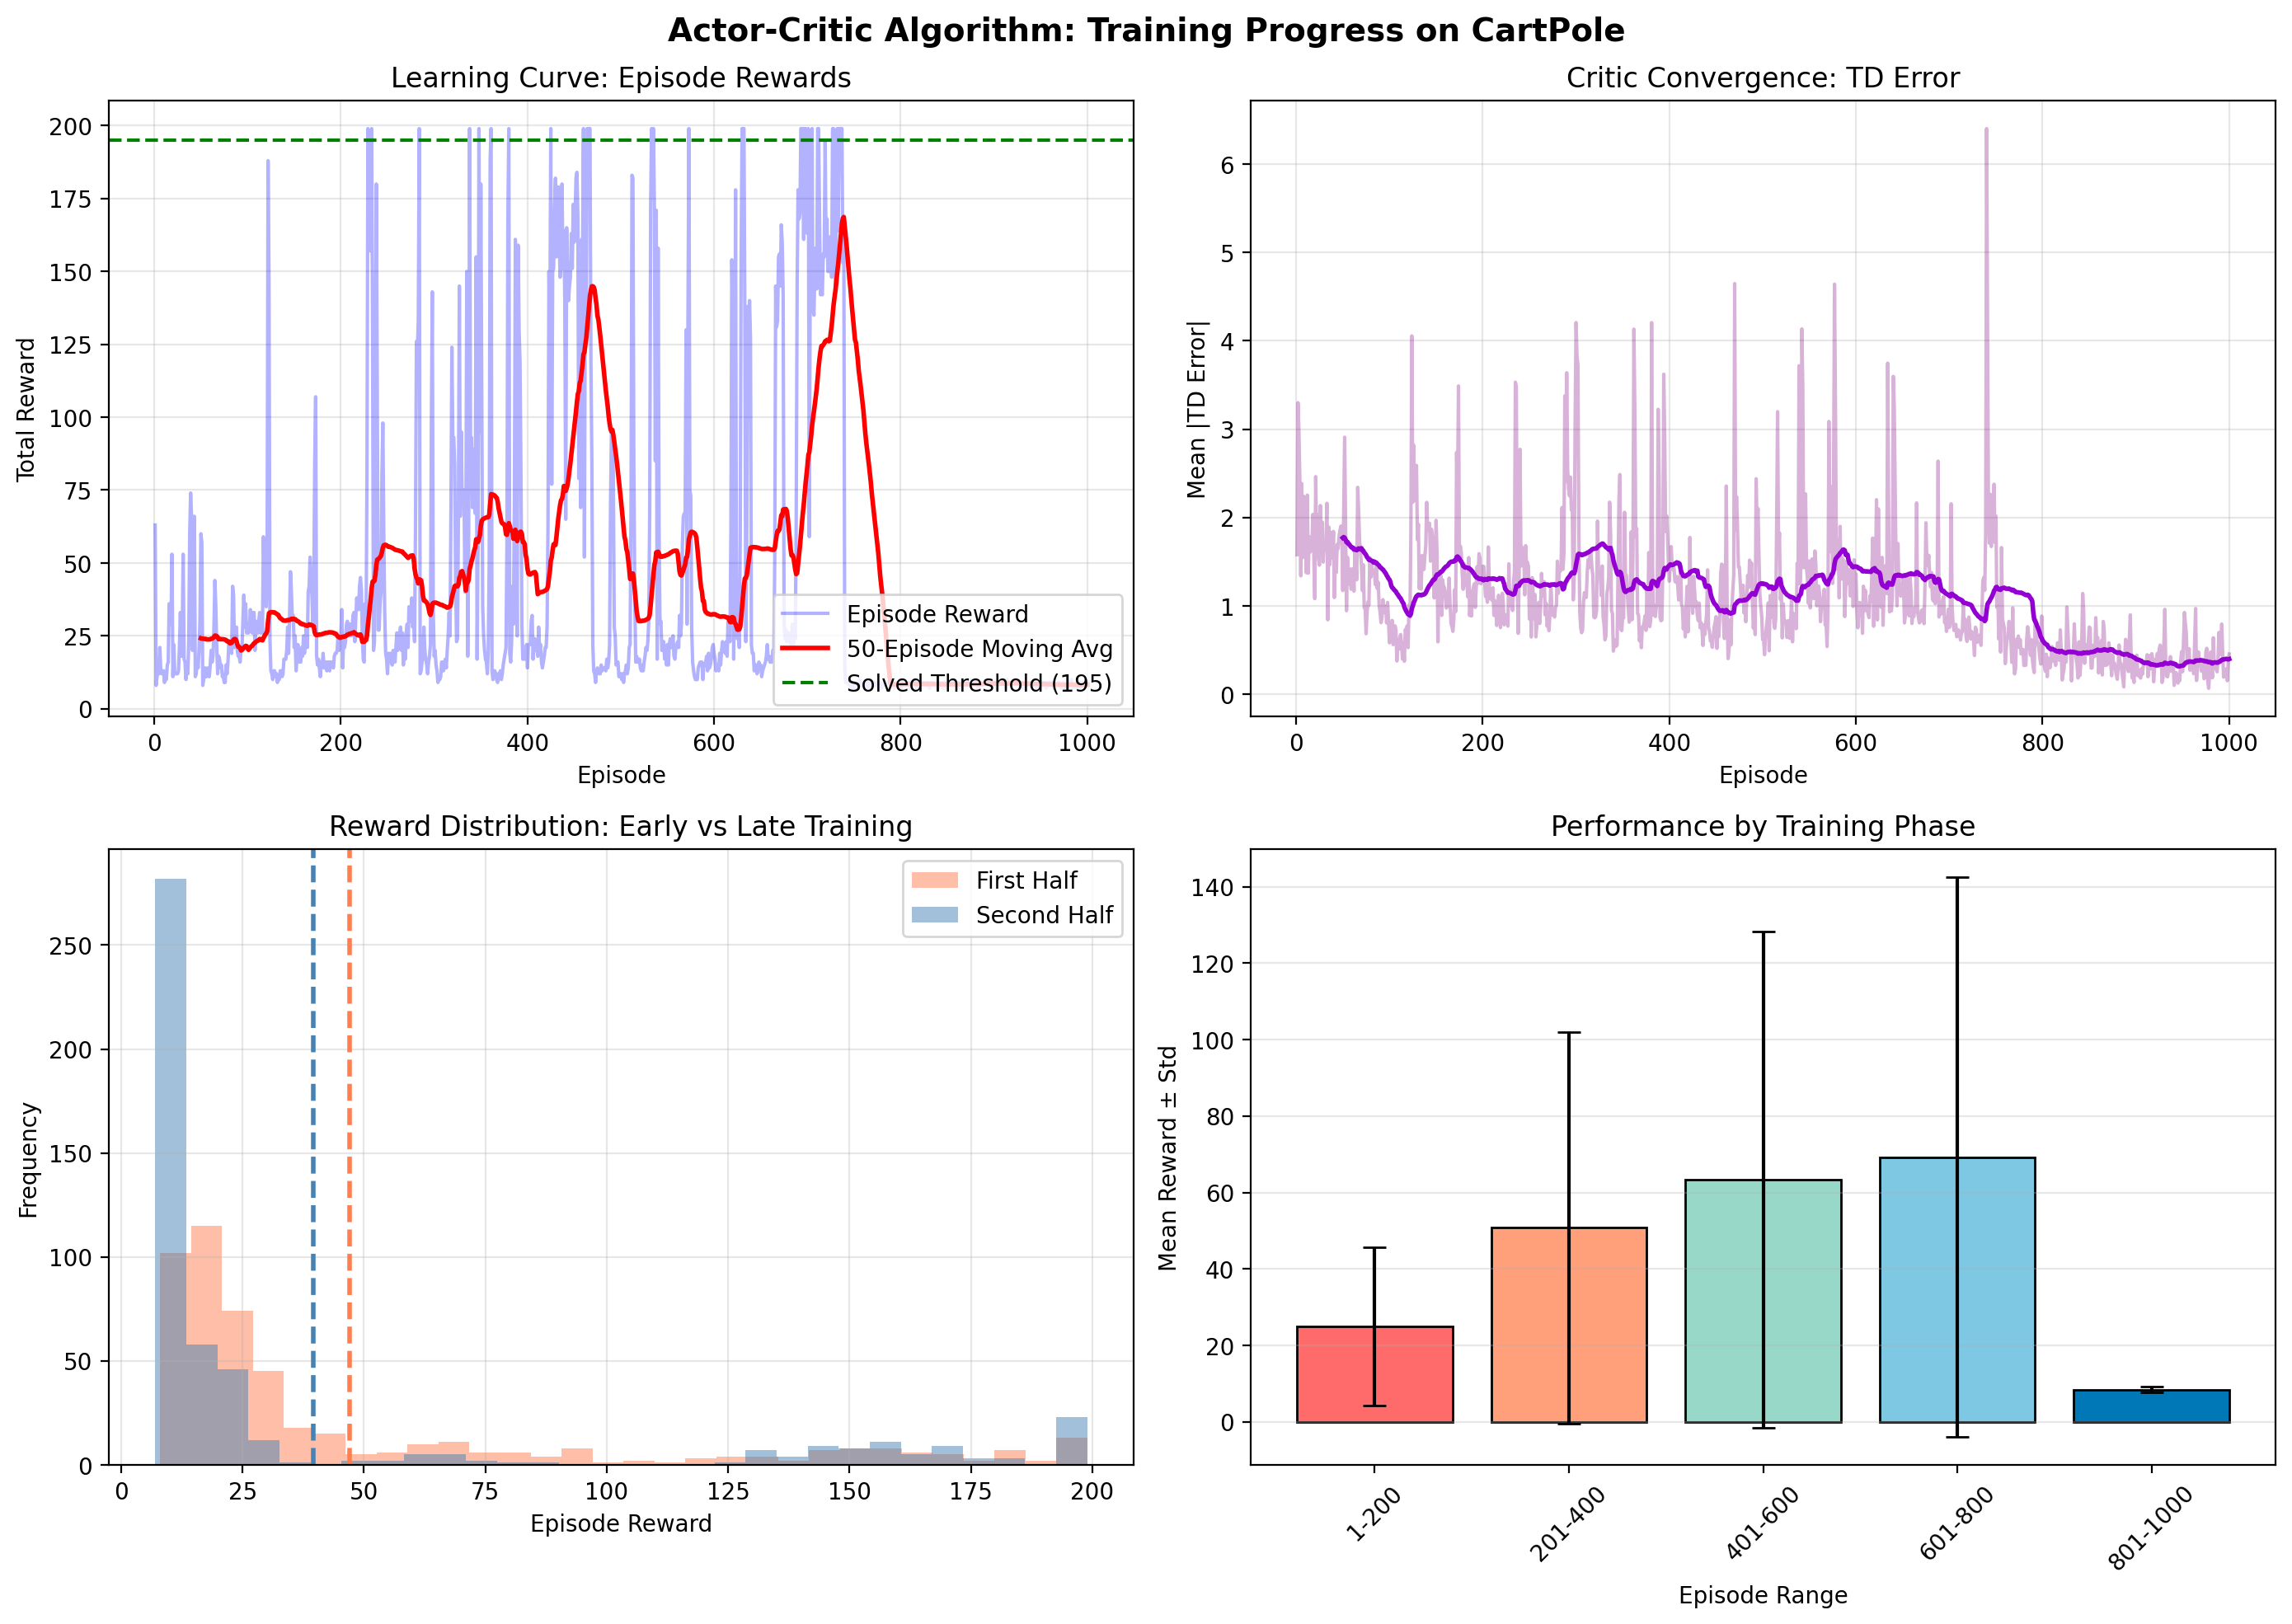


TRAINING SUMMARY
Total Episodes: 1000
Final 100 Episode Avg: 8.3
Best Episode Reward: 199
Final TD Error (avg last 100): 0.3614

✗ Not yet solved. Need 186.7 more avg reward.


In [5]:
def plot_training_results(history, window=50):
    """Plot comprehensive training results."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Actor-Critic Algorithm: Training Progress on CartPole', 
                 fontsize=14, fontweight='bold')
    
    rewards = history['rewards']
    td_errors = history['td_errors']
    episodes = range(1, len(rewards) + 1)
    
    # Plot 1: Episode Rewards
    ax1 = axes[0, 0]
    ax1.plot(episodes, rewards, alpha=0.3, color='blue', label='Episode Reward')
    # Moving average
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window, len(rewards) + 1), moving_avg, 
             color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
    ax1.axhline(y=195, color='green', linestyle='--', label='Solved Threshold (195)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Learning Curve: Episode Rewards')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: TD Error
    ax2 = axes[0, 1]
    ax2.plot(episodes, td_errors, alpha=0.3, color='purple')
    # Moving average of TD error
    td_moving_avg = np.convolve(td_errors, np.ones(window)/window, mode='valid')
    ax2.plot(range(window, len(td_errors) + 1), td_moving_avg, 
             color='darkviolet', linewidth=2)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Mean |TD Error|')
    ax2.set_title('Critic Convergence: TD Error')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Reward Distribution
    ax3 = axes[1, 0]
    # Split into early and late training
    split = len(rewards) // 2
    ax3.hist(rewards[:split], bins=30, alpha=0.5, label='First Half', color='coral')
    ax3.hist(rewards[split:], bins=30, alpha=0.5, label='Second Half', color='steelblue')
    ax3.axvline(x=np.mean(rewards[:split]), color='coral', linestyle='--', linewidth=2)
    ax3.axvline(x=np.mean(rewards[split:]), color='steelblue', linestyle='--', linewidth=2)
    ax3.set_xlabel('Episode Reward')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Reward Distribution: Early vs Late Training')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Performance Summary
    ax4 = axes[1, 1]
    # Calculate statistics for different training phases
    n_phases = 5
    phase_size = len(rewards) // n_phases
    phases = []
    means = []
    stds = []
    
    for i in range(n_phases):
        start = i * phase_size
        end = (i + 1) * phase_size if i < n_phases - 1 else len(rewards)
        phase_rewards = rewards[start:end]
        phases.append(f'{start+1}-{end}')
        means.append(np.mean(phase_rewards))
        stds.append(np.std(phase_rewards))
    
    x_pos = np.arange(len(phases))
    bars = ax4.bar(x_pos, means, yerr=stds, capsize=5, 
                   color=['#FF6B6B', '#FFA07A', '#98D8C8', '#7EC8E3', '#0077B6'],
                   edgecolor='black', linewidth=1)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(phases, rotation=45)
    ax4.set_xlabel('Episode Range')
    ax4.set_ylabel('Mean Reward ± Std')
    ax4.set_title('Performance by Training Phase')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('actor_critic_algorithm_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Episodes: {len(rewards)}")
    print(f"Final 100 Episode Avg: {np.mean(rewards[-100:]):.1f}")
    print(f"Best Episode Reward: {max(rewards):.0f}")
    print(f"Final TD Error (avg last 100): {np.mean(td_errors[-100:]):.4f}")
    
    # Check if solved
    if np.mean(rewards[-100:]) >= 195:
        print("\n✓ Environment SOLVED! (Avg reward >= 195 over last 100 episodes)")
    else:
        print(f"\n✗ Not yet solved. Need {195 - np.mean(rewards[-100:]):.1f} more avg reward.")

# Generate visualization
plot_training_results(history)

## Analysis and Discussion

### Key Observations

1. **Variance Reduction**: The critic's baseline reduces variance in policy gradient estimates compared to REINFORCE

2. **Bias-Variance Tradeoff**: TD learning introduces some bias through bootstrapping but significantly reduces variance

3. **Sample Efficiency**: Actor-Critic methods can learn from incomplete episodes (online learning)

### Advantages of Actor-Critic

- **Lower variance** than pure policy gradient methods
- **Online learning** capability (no need to wait for episode completion)
- **Continuous action spaces** are naturally supported
- **Function approximation** scales to high-dimensional problems

### Limitations

- **Two sets of parameters** to tune (actor and critic learning rates)
- **Potential instability** from bootstrapping errors
- **Sensitive to hyperparameters** like feature representation

### Extensions

Modern variants include:
- **A2C/A3C**: Asynchronous advantage actor-critic
- **PPO**: Proximal Policy Optimization with clipped objectives
- **SAC**: Soft Actor-Critic with entropy regularization
- **TD3**: Twin Delayed DDPG for continuous control

## References

1. Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*. MIT Press.

2. Konda, V. R., & Tsitsiklis, J. N. (2000). Actor-critic algorithms. *Advances in Neural Information Processing Systems*, 12.

3. Mnih, V., et al. (2016). Asynchronous methods for deep reinforcement learning. *International Conference on Machine Learning*.

4. Schulman, J., et al. (2017). Proximal policy optimization algorithms. *arXiv preprint arXiv:1707.06347*.